In [30]:
#Load Packages
import glob
import pandas as pd
import re
import numpy as np
from plotnine import *
import warnings
from sklearn.cluster import KMeans

In [6]:
warnings.filterwarnings('ignore')

In [348]:
#RDQ
rdqPre = pd.read_spss('../Data/PrePostMeasures/RDQPre_1.sav')
rdqPost = pd.read_spss('../Data/PrePostMeasures/RDQPost_1.sav')
rdqPre

#Satisfaction
satOld = pd.read_spss('../Data/PHPSatisfaction/EndofTreatmentSurveyData/EOT Verfication_1.sav')
satNew = pd.read_spss('../Data/DischargePacket/2022-06-06 dc.sav')

#Diagnosis
dx = pd.read_spss('../Data/DemosDx/Diagnosis_1.sav')
demo = pd.read_spss('../Data/DemosDx/Demographics Form_1.sav')

In [353]:
#RDQ Arrangement: Symptoms, Coping Ability, Positive Mental Health, Functioning, Well-Being and Life Satisfaction
rdqPre.ID1 = rdqPre.ID1.astype('object')
rdqPost.ID1 = rdqPost.ID1.astype('object')
rdqPre = rdqPre.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})
rdqPost = rdqPost.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})

#Convert reverse items
for i in [29,30,48,49,50,51,52] :
    colname1 = 'rdqpre_' + str(i) + '_1'
    colname2 = 'rdqpost_' + str(i) + '_1'
    rdqPre[colname1] = abs(rdqPre[colname1].astype('float') - 2)
    rdqPost[colname2] = abs(rdqPost[colname2].astype('float') - 2)

In [356]:
#Agregate scores of different RDQ sections
rdqPre['pre_sym'] = rdqPre.iloc[:,1:26].mean(axis = 1)
rdqPre['pre_cope'] = rdqPre.iloc[:,26:31].mean(axis = 1)
rdqPre['pre_pmh'] = rdqPre.iloc[:,31:43].mean(axis = 1)
rdqPre['pre_fun'] = rdqPre.iloc[:,43:53].mean(axis = 1)
rdqPre['pre_well'] = rdqPre.iloc[:,53:61].mean(axis = 1)

rdqPost['post_sym'] = rdqPost.iloc[:,1:26].mean(axis = 1)
rdqPost['post_cope'] = rdqPost.iloc[:,26:31].mean(axis = 1)
rdqPost['post_pmh'] = rdqPost.iloc[:,31:43].mean(axis = 1)
rdqPost['post_fun'] = rdqPost.iloc[:,43:53].mean(axis = 1)
rdqPost['post_well'] = rdqPost.iloc[:,53:61].mean(axis = 1)

rdq = pd.merge(rdqPre, rdqPost, on = 'ID1', how = 'inner')

In [357]:
#Merge old and new overall satisfaction 
satGlobalOld = satOld.loc[:,['PHP_ID_1','OVERALL_1', 'IMPRV_1']].rename(columns = {'PHP_ID_1': 'ID1', 'OVERALL_1': 'overall1',
                                                                                   'IMPRV_1': 'imprv1'})
satGlobalNew = satNew.loc[:,['id1','overall_1', 'imprv_1']].rename(columns = {'id1': 'ID1', 'overall_1': 'overall1',
                                                                              'imprv_1': 'imprv1'})
satGlobal = pd.concat([satGlobalOld, satGlobalNew],axis = 0)
satGlobal = satGlobal[satGlobal.ID1 != 0]
satGlobal.ID1 = satGlobal.ID1.astype('object')

print('N of people who were administered with the discharge package:', satGlobal.shape[0]) 

N of people who were administered with the discharge package: 3811


In [358]:
print('Overall Satisfaction Missing Values = ', sum(satGlobal.overall1.isnull()),'\n'
      'Overall Improvement Missing Values = ', sum(satGlobal.imprv1.isnull()))

Overall Satisfaction Missing Values =  49 
Overall Improvement Missing Values =  46


In [359]:
df = pd.merge(satGlobal, rdq, how = 'inner', on = 'ID1')
df = pd.merge(df, dx, how = 'left', on = 'ID1')
df = pd.merge(df, demo, how = 'left', on = 'ID1')

In [360]:
df = df[df.filter(regex='rdqpre').isnull().sum(axis=1) <=10]
df = df[df.filter(regex='rdqpost').isnull().sum(axis=1) <=10]
print('People who completed the program and have less than 10 missing values in RDQ at intake and discharge', 
      df.shape[0])

People who completed the program and have less than 10 missing values in RDQ at intake and discharge 2711


In [361]:
df_long0 = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')

df_long0 = \
pd.melt(df_long0, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long0.rdqvar = df_long0.rdqvar.astype('category').cat.reorder_categories(
    ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well'])
df_long0.satvar = df_long0.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])


df_long = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')
df_long = \
pd.melt(df_long, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long.rdqvar = df_long.rdqvar.astype('category').cat.reorder_categories(
    ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'])
df_long.satvar = df_long.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])


#Compute Change Score (Larger scale = Larger Improvement)
df['change_sym'] = df.pre_sym - df.post_sym 
df['change_cope'] = df.post_cope - df.pre_cope
df['change_pmh'] = df.post_pmh - df.pre_pmh
df['change_fun'] = df.post_fun - df.pre_fun
df['change_well'] = df.post_well - df.pre_well

df_long2 = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')

df_long2 = \
pd.melt(df_long2, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long2.rdqvar = df_long2.rdqvar.astype('category').cat.reorder_categories(
    ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'])
df_long2.satvar = df_long2.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])

In [362]:
df[['overall1', 'imprv1', 'pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well']].corr()

,overall1,imprv1,pre_sym,pre_cope,pre_pmh,pre_fun,pre_well
overall1,1.000000,0.557869,-0.021413,0.025154,0.030022,0.023102,0.041632
imprv1,0.557869,1.000000,-0.097867,0.095942,0.158059,0.129033,0.135814
pre_sym,-0.021413,-0.097867,1.000000,-0.484959,-0.535086,-0.560089,-0.494452
pre_cope,0.025154,0.095942,-0.484959,1.000000,0.547704,0.496269,0.499837
pre_pmh,0.030022,0.158059,-0.535086,0.547704,1.000000,0.584589,0.756277
pre_fun,0.023102,0.129033,-0.560089,0.496269,0.584589,1.000000,0.600678
pre_well,0.041632,0.135814,-0.494452,0.499837,0.756277,0.600678,1.000000


In [363]:
df[['overall1', 'imprv1', 'post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well']].corr()

,overall1,imprv1,post_sym,post_cope,post_pmh,post_fun,post_well
overall1,1.000000,0.557869,-0.232156,0.222340,0.277009,0.228834,0.262392
imprv1,0.557869,1.000000,-0.457884,0.469925,0.552663,0.445714,0.532114
post_sym,-0.232156,-0.457884,1.000000,-0.687098,-0.687886,-0.686617,-0.675026
post_cope,0.222340,0.469925,-0.687098,1.000000,0.700477,0.697753,0.700857
post_pmh,0.277009,0.552663,-0.687886,0.700477,1.000000,0.716889,0.866689
post_fun,0.228834,0.445714,-0.686617,0.697753,0.716889,1.000000,0.763448
post_well,0.262392,0.532114,-0.675026,0.700857,0.866689,0.763448,1.000000


In [395]:
#Means of change scores
df[['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].mean(axis = 0)

change_sym     0.527292
change_cope    0.500564
change_pmh     0.552289
change_fun     0.432705
change_well    0.585467
dtype: float64

In [396]:
df[['overall1', 'imprv1', 'change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].corr()

,overall1,imprv1,change_sym,change_cope,change_pmh,change_fun,change_well
overall1,1.000000,0.557869,0.218829,0.176180,0.243768,0.193641,0.216945
imprv1,0.557869,1.000000,0.383187,0.335784,0.407886,0.307530,0.401322
change_sym,0.218829,0.383187,1.000000,0.529319,0.635684,0.572509,0.585998
change_cope,0.176180,0.335784,0.529319,1.000000,0.576605,0.539565,0.568636
change_pmh,0.243768,0.407886,0.635684,0.576605,1.000000,0.621767,0.763486
change_fun,0.193641,0.307530,0.572509,0.539565,0.621767,1.000000,0.655897
change_well,0.216945,0.401322,0.585998,0.568636,0.763486,0.655897,1.000000


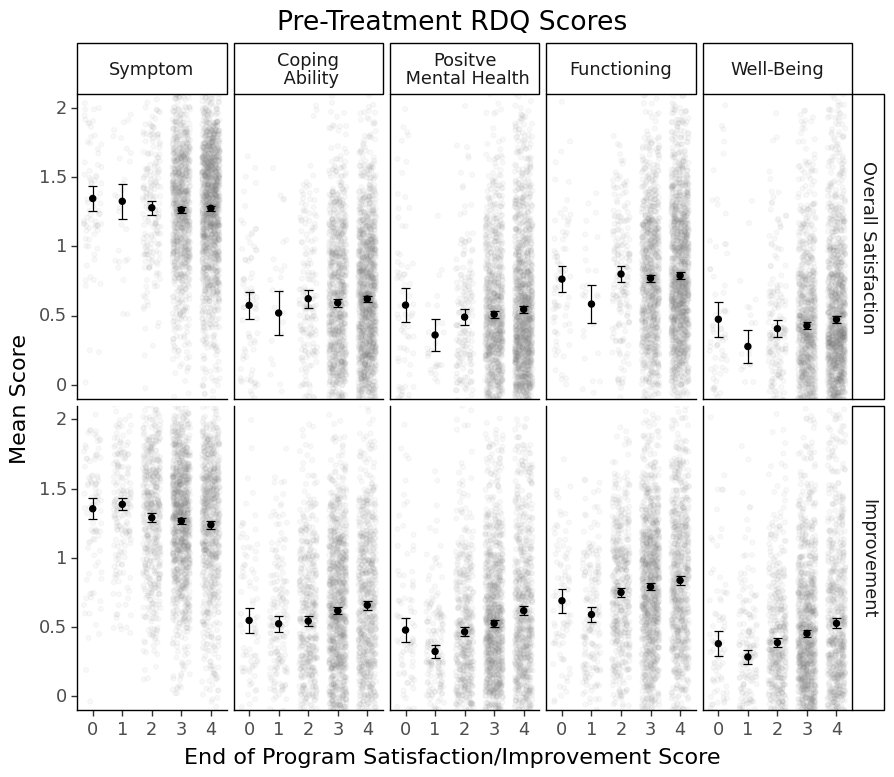

<ggplot: (8789392412332)>

In [366]:
def facet_label(s):
    if 'sym' in s: return('Symptom')
    if 'cope' in s: return ('Coping\n Ability')
    if 'pmh' in s: return('Positve\n Mental Health')
    if 'fun' in s: return ('Functioning')
    if 'well' in s: return('Well-Being')
    if 'overall' in s: return('Overall Satisfaction')
    if 'imprv' in s: return('Improvement')
    
ggplot(df_long0, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Pre-Treatment RDQ Scores')


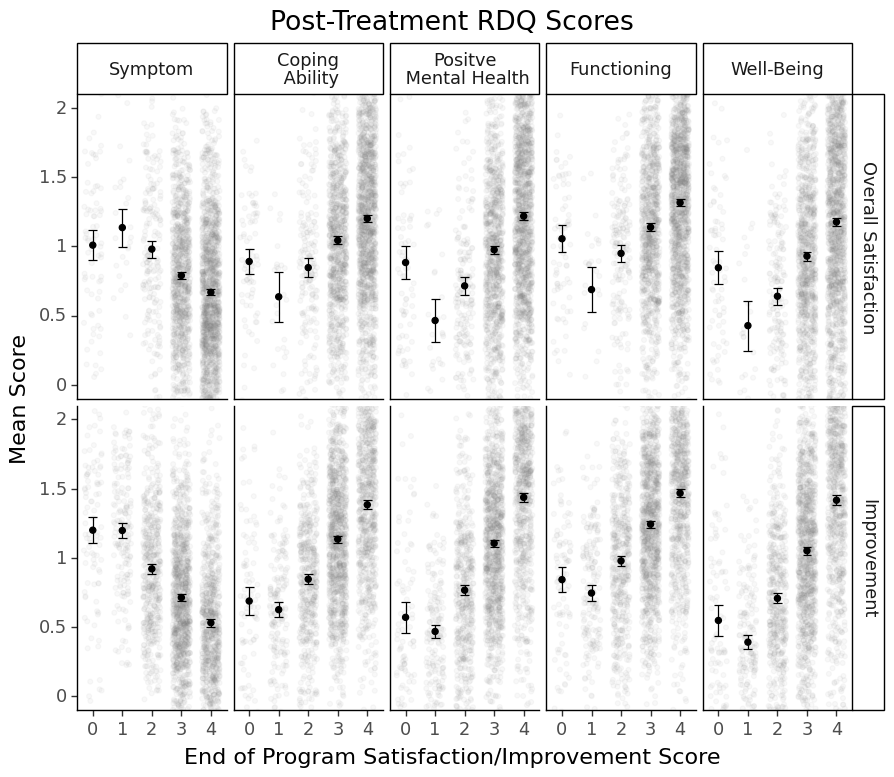

<ggplot: (8789399485431)>

In [367]:
ggplot(df_long, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Post-Treatment RDQ Scores')

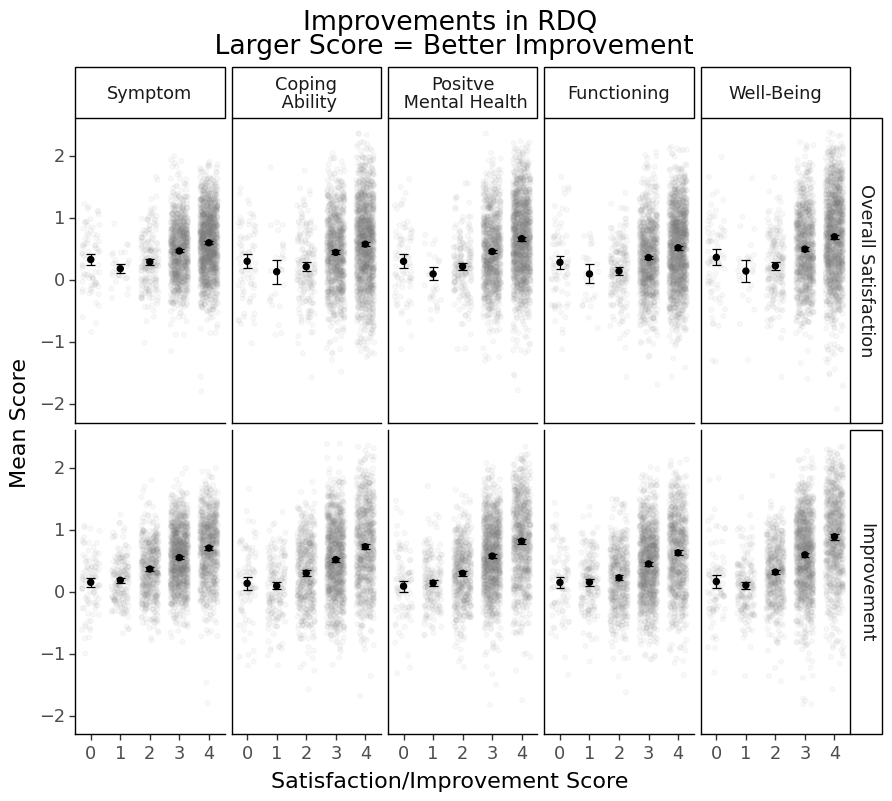

<ggplot: (8789394153716)>

In [368]:
ggplot(df_long2, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     xlab('Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Improvements in RDQ\n Larger Score = Better Improvement')

In [369]:
from sklearn import cluster
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics

In [370]:
X = df[df.mddrnp_1.str.contains('Curr, Prin') | df.mddsnp_1.str.contains('Curr, Prin')]
X[['mddrnp_1', 'mddsnp_1']]
Xpre = X.filter(regex='rdqpre')
Xpost = X.filter(regex='rdqpost') 

In [371]:
Xpre.columns = Xpre.columns.str.replace('pre','')
Xpost.columns = Xpost.columns.str.replace('post','')

In [372]:
Xchange = Xpre.astype('float').subtract(Xpost.astype('float'), axis = 0, fill_value = 0)

In [373]:
Xpost_group = X.filter(regex='^post_')
Xpost_group
Xchange_group = X.filter(regex='^change_')
Xchange_group

,change_sym,change_cope,change_pmh,change_fun,change_well
17,0.840000,1.4,1.750000,-0.200000,0.750000
18,0.920000,0.6,0.250000,0.200000,0.625000
26,0.120000,0.6,0.666667,0.100000,0.875000
27,0.120000,0.0,0.083333,0.000000,0.125000
30,0.240000,0.2,0.416667,0.400000,0.250000
...,...,...,...,...,...
3408,0.223333,-0.2,-0.083333,0.200000,0.250000
3409,0.683333,1.2,0.916667,0.833333,1.571429
3411,0.080000,0.0,-0.083333,0.200000,0.375000
3412,0.080000,0.0,-0.083333,0.200000,0.375000


In [374]:
#Imputation 
target = Xchange
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(target)
IterativeImputer(random_state=0)
X_imp = imp.transform(target)

In [375]:
distortions = []
for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_imp)
    distortions.append(kmeanModel.inertia_)
    

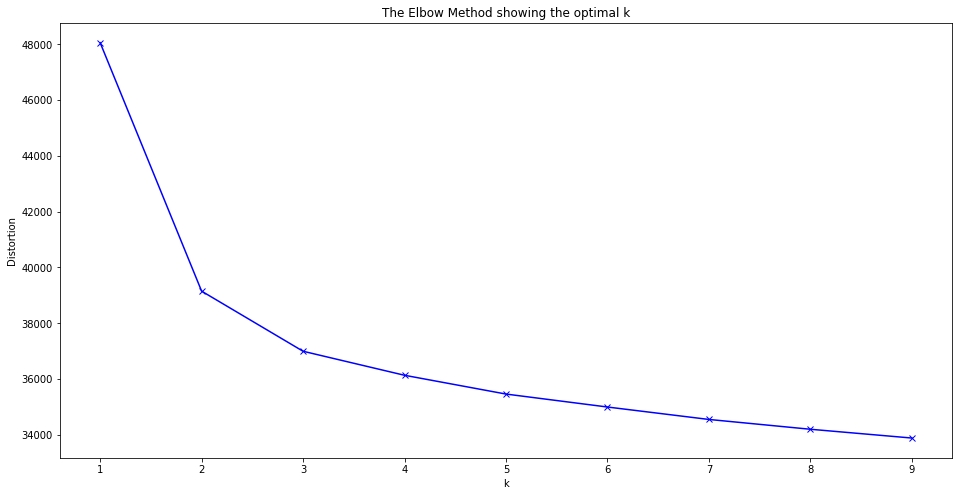

In [376]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [377]:
metrics.silhouette_score(X_imp, labels, metric='euclidean')

0.16062960840816928

In [378]:
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(X_imp)
distortions.append(kmeanModel.inertia_)
labels = kmeanModel.labels_

In [379]:
X['labels'] = labels

In [380]:
print(X[labels == 0].change_sym.mean(),
      X[labels == 0].change_pmh.mean(),
      X[labels == 0].change_cope.mean(),
      X[labels == 0].change_fun.mean(),
      X[labels == 0].change_well.mean())

0.2939405055041861 0.2460101753916187 0.21965098634294386 0.17637807700399746 0.2357739851102683


In [381]:
print(X[labels == 1].change_sym.mean(),
      X[labels == 1].change_pmh.mean(),
      X[labels == 1].change_cope.mean(),
      X[labels == 1].change_fun.mean(),
      X[labels == 1].change_well.mean())

0.8796615585708683 1.0596865602590793 0.9188588007736944 0.8209885799103356 1.1010541621228644


In [394]:
print(X[labels == 1].change_sym.mean() - X[labels == 0].change_sym.mean(),
      X[labels == 1].change_pmh.mean() - X[labels == 0].change_pmh.mean(),
      X[labels == 1].change_cope.mean() - X[labels == 0].change_cope.mean(),
      X[labels == 1].change_fun.mean() - X[labels == 0].change_fun.mean(),
      X[labels == 1].change_well.mean() - X[labels == 0].change_well.mean())

0.5857210530666821 0.8136763848674605 0.6992078144307505 0.6446105029063381 0.8652801770125962


In [314]:
from scipy.stats import ttest_ind

In [393]:
print(ttest_ind(X[labels == 1].change_sym,X[labels == 0].change_sym, nan_policy = 'omit'),'\n',
ttest_ind(X[labels == 1].change_pmh,X[labels == 0].change_pmh, nan_policy = 'omit'),'\n',
ttest_ind(X[labels == 1].change_cope,X[labels == 0].change_cope, nan_policy = 'omit'),'\n',
ttest_ind(X[labels == 1].change_fun,X[labels == 0].change_fun, nan_policy = 'omit'),'\n',
ttest_ind(X[labels == 1].change_well,X[labels == 0].change_well, nan_policy = 'omit'))

Ttest_indResult(statistic=33.08234701603569, pvalue=3.871721913772982e-171) 
 Ttest_indResult(statistic=38.05233289101712, pvalue=1.584026707494534e-208) 
 Ttest_indResult(statistic=26.023958545795974, pvalue=3.0088709761739462e-118) 
 Ttest_indResult(statistic=26.92272206121235, pvalue=2.665443187247355e-125) 
 Ttest_indResult(statistic=35.1655642098324, pvalue=8.822279346621163e-187)


In [389]:
print(X.change_sym.corr(X.imprv1),
      X.change_pmh.corr(X.imprv1),
      X.change_cope.corr(X.imprv1),
      X.change_fun.corr(X.imprv1),
      X.change_well.corr(X.imprv1),
      X.labels.corr(X.imprv1))

0.43968863142831816 0.48724824963302227 0.388574830999211 0.35899507014384974 0.4919824662672088 0.48243083037548823


In [390]:
print(X.change_sym.corr(X.overall1),
      X.change_pmh.corr(X.overall1),
      X.change_cope.corr(X.overall1),
      X.change_fun.corr(X.overall1),
      X.change_well.corr(X.overall1),
      X.labels.corr(X.overall1))

0.25942796263882184 0.28927390982858797 0.1922385235286086 0.2191004514468665 0.23566231581934097 0.2750787966425771


In [391]:
print(X.imprv1[labels == 0].mean(),
X.imprv1[labels == 1].mean(),
X.imprv1[labels == 2].mean())

print(X.overall1[labels == 0].mean(),
X.overall1[labels == 1].mean(),
X.overall1[labels == 2].mean())

2.393225331369661 3.385796545105566 nan
3.1325478645066274 3.605009633911368 nan


In [392]:
metrics.calinski_harabasz_score(X_imp, labels)

273.30693782088383